> 이 문서의 폰트크기는 브라우저 인쇄시 인쇄 배율 75%로 최적화 되어 있음


# 예제 1. MNIST  분류 : CNN (일반)

> <학습 목표>    
> - 파이토치 모듈 API 기반 직렬 결합 방식의 CNN 모델의 일반적인 제작 기법 이해

> < 코드 구성>   
> 1. 학습 데이터 구축   
>    (1) 학습테이터의 첫번째 이미지의 확인하기 
>    (2) 학습 데이터의 첫 100개 이미지 보기
> 2. 데이터셋 및 데이터로더 객체 생성   
> 3. CNN 모델 클래스 및 모델 성능 측정 함수 정의   
>    (1) CNN 모델 클래스   
>     (2) 학습된 모델의 추론 및 정확도 산출 함수   
> 4. 훈련된 모델 사용하기   
>     (1) 한 개의 입력 이미지 분류 하기   
>     (2) 검증용(테스트) 이미지 각각을 분류하여 잘못 분류된 이미지들 보기
>     (3) 훈련용 이미지 각각을 분류하여 잘못 분류된 이미지들 보기

In [4]:
# multi line 출력을 위한 셀 -- 필요시 주석해제 후 이 셀을 실행시키기 바람
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)

from torchvision.datasets import MNIST
from torchvision import transforms
import tqdm

## 1. 학습 데이터셋 구축


In [6]:
##### 입력 샘플과  X와 목표치 D
mnist_train = MNIST("./data",
                        train=True, download=True,
                        transform=transforms.ToTensor())

# 시험용  데이터 가져오기
mnist_test = MNIST("./data",
                    train=False, download=True,
                    transform=transforms.ToTensor())

def data_info():
    print(len(mnist_train))
    print(len(mnist_test))
    print(mnist_train.classes)
    print(mnist_train.class_to_idx)

data_info()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

60000
10000
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


### (1) 학습데이터의 첫번째 이미지의 확인하기

label = 5


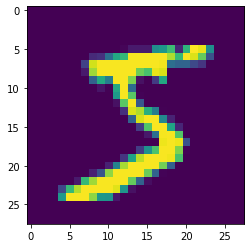

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

In [7]:
img, label = mnist_train[0]
print("label =", label)
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(img.size())
print(img)

### (2) 학습 데이터의 첫 100개 이미지 보기

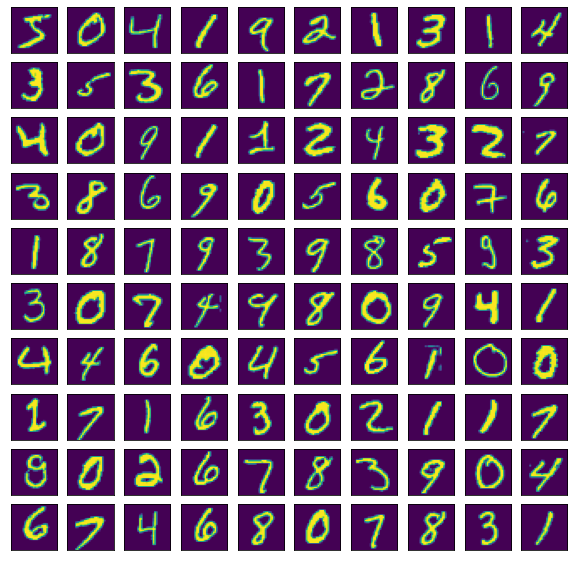

In [8]:
class_names = ['0', '1','2', '3', '4', '5', '6', '7', '8', '9']

fig = plt.figure(figsize=(10, 10))
i = 0
for img, label in mnist_train:
    ax = fig.add_subplot(10, 10, 1 + i, xticks=[], yticks=[])
    i = i + 1
    plt.imshow(img.permute(1, 2, 0))
    if i == 100:
        break     

Text(0.5, 1.0, '0')

Text(0.5, 1.0, '1')

Text(0.5, 1.0, '2')

Text(0.5, 1.0, '3')

Text(0.5, 1.0, '4')

Text(0.5, 1.0, '5')

Text(0.5, 1.0, '6')

Text(0.5, 1.0, '7')

Text(0.5, 1.0, '8')

Text(0.5, 1.0, '9')

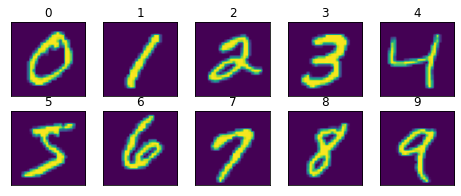

In [9]:
# 각 클래스별 첫번째 이미지 디스플레이 하기
class_names = ['0', '1','2', '3', '4', '5', '6', '7', '8', '9']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in mnist_train if label == i)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

## 2. 데이터로더 객체 생성
- GPU 실행을 위한 데이터 변환 내용도 들어 있으며, 필요시 주석해제 후 GPU 기반 실행 실습 요망

In [10]:
# 배치 크기가 128인 DataLoader를 각각 작성
batch_size=128
train_loader = DataLoader(mnist_train, 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(mnist_test,
                          batch_size=batch_size, shuffle=False)

## 3. CNN 모델 클래스 및 모델 성능 측정 함수 정의 

### (1) CNN 모델 클래스

In [11]:
## (N, C, H, W) Tensor를 (N, C*H*W)로 변형 계층 (합성곱 출력을 MLP에 전달할 때 사용)
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
 
        return x.view(sizes[0], -1)

## 2개의 컨볼루션 계층
    # conv1 : 1채널 입력, 32개 5×5 필터, conv2 : 32채널 입력, 64개 5×5 필터
    # Batch Normalization과 Dropout 적용
## 2개의 FC 채널
    # fc1은 Batch Normalization과 Dropout 적용
## 활성화함수는 최종 출력 계층만 제외하고 relu()를 사용

conv_net = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size= 5),  #  32 x 24 x 24
    nn.MaxPool2d(2),                   #  32 x 12 x 12
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    
    nn.Conv2d(32, 64, kernel_size= 5),  #  64 x 8 x 8
    nn.MaxPool2d(2),                    #  64 x 4 x 4
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    
    FlattenLayer()
)

# 위 합성곱 계층들에 의한 최종이미지 크기 추출
test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]

# 2 계층 MLP
fnn = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)
# 최종 CNN
model = nn.Sequential(
    conv_net,
    fnn
)

# ADAMS의 optimizer 생성
optimizer = optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# 크로스 엔트로피 오차 함수 생성
loss_fn = nn.CrossEntropyLoss()

### (2) 학습된 모델의 추론 및 정확도 산출 함수

In [12]:
# 추론 및 정확도 산출
def eval_model(model, data_loader, device="cpu"):
    # Dropout 및 BatchNorm을 무효화
    model.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        # to 메서드로 계산을 실행할 디바이스로 전송
        x = x.to(device)
        y = y.to(device)
        # 확률이 가장 큰 클래스를 예측(리스트 2.1 참조)
        # 여기선 forward（추론） 계산이 전부이므로 자동 미분에
        # 필요한 처리는 off로 설정해서 불필요한 계산을 제거
        with torch.no_grad():
            _, y_pred = model(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)

    # 미니 배치 단위의 예측 결과 등을 하나로 묶는다
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 예측 정확도 계산
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

## 3. CNN 훈련 
### (1) CNN 훈련 시키기
- 시간 상 4 에포크 분량 훈련 / cpu 환경

In [13]:
# 신경망의 모든 파라미터
device = "cpu"
#device = "cuda:0"

model.to(device)

# 훈련 실행
EPOCHS = 4

log_train_loss = []
log_train_acc = []
log_valid_acc = []

#opt = optimizer(model.parameters())

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    # 신경망을 훈련 모드로 설정
    model.train()
    n = 0
    acc = 0
    i = 0
    # 시간이 많이 걸리므로 tqdm을 사용해서 진행바를 표시
    for i, (x_mb, d_mb) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        x_mb = x_mb.to(device)
        d_mb = d_mb.to(device)
        h = model(x_mb)
        loss = loss_fn(h, d_mb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n += len(x_mb)
        _, y_pred = h.max(1)
        acc += (d_mb == y_pred).sum().item()

    log_train_loss.append(epoch_loss / i)
    # 훈련 데이터의 예측 정확도
    log_train_acc.append(acc / n)

    # 검증 데이터의 예측 정확도
    log_valid_acc.append(eval_model(model, valid_loader, device))
    # epoch의 결과 표시
    print(epoch, log_train_loss[-1], log_train_acc[-1], log_valid_acc[-1], flush=True)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): FlattenLayer()
  )
  (1): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): FlattenLayer()
  )
  (1): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:36<00:00, 13.02it/s]


0 0.13356724784223953 0.9618 0.9873999953269958


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): FlattenLayer()
  )
  (1): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:35<00:00, 13.05it/s]


1 0.05203833594086429 0.9845833333333334 0.9901999831199646


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): FlattenLayer()
  )
  (1): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:35<00:00, 13.32it/s]


2 0.04257304192337598 0.9865666666666667 0.9907000064849854


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): FlattenLayer()
  )
  (1): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:35<00:00, 13.27it/s]


3 0.031804399836498 0.9900666666666667 0.9930999875068665


### (2) 최종 오차/정확도 출력 및 에포크별 오차/정확도 그래프 디스플레이 하기

최종 Training Accuracy = 0.9901   최종 Validation Accuracy = 0.9931


<AxesSubplot:>

Text(0.5, 1.0, 'Train accuracy')

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'accuracy')

([<matplotlib.axis.XTick at 0x2972ee14b50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

([<matplotlib.axis.YTick at 0x2972edbc100>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

<AxesSubplot:>

Text(0.5, 1.0, 'Validation Accuracy')

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'accuracy')

([<matplotlib.axis.XTick at 0x2972ee77460>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

([<matplotlib.axis.YTick at 0x2972eeacd90>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

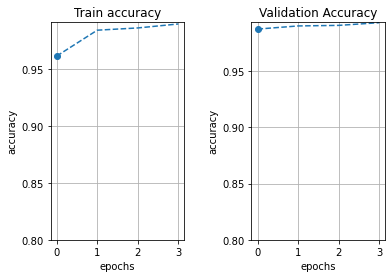

In [14]:
print("최종 Training Accuracy = %1.4f" % log_train_acc[-1], end='   ')
print("최종 Validation Accuracy = %1.4f" % log_valid_acc[-1])

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), log_train_acc, 'o--', markevery=10)
plt.title("Train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xticks(range(0, EPOCHS, 1))
plt.yticks(np.arange(0.8, 1, 0.05))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS),log_valid_acc, 'o--', markevery=10)
plt.title("Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xticks(range(0, EPOCHS, 1))
plt.yticks(np.arange(0.8, 1, 0.05))
plt.grid()

plt.subplots_adjust(wspace=0.5)
plt.show()

## 4. 훈련된 모델 사용하기
### (1) 한 개의 입력 이미지 분류 하기

torch.Size([1, 28, 28])


label = 8
torch.Size([1, 1, 28, 28])
예측 = 8
정확하게 분류하였읍니다.


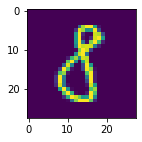

In [15]:
TEST_IMAGE_INDEX = 1200
img, label = mnist_test[TEST_IMAGE_INDEX]
print(img.size())
fig = plt.figure(figsize=(3,2))
plt.imshow(img.permute(1, 2, 0))
print("label =", label)

img = torch.unsqueeze(img, 0)  # 4 
print(img.size())
_, y_pred = model(img).max(1)
print("예측 =", y_pred.item())
if label == y_pred.item():
    print("정확하게 분류하였읍니다.")
else:
    print("분류를 제대로 하지 못했읍니다.")

### (2) 테스트 이미지 각각을 분류하여 잘못 분류된 이미지들 보기

분류 실패 이미지 개수 = 69


Text(0.5, 1.0, '4/6 247')

Text(0.5, 1.0, '6/0 445')

Text(0.5, 1.0, '8/2 582')

Text(0.5, 1.0, '1/8 619')

Text(0.5, 1.0, '6/0 965')

Text(0.5, 1.0, '6/5 1014')

Text(0.5, 1.0, '7/2 1226')

Text(0.5, 1.0, '9/4 1232')

Text(0.5, 1.0, '7/1 1260')

Text(0.5, 1.0, '8/0 1319')

Text(0.5, 1.0, '5/3 1393')

Text(0.5, 1.0, '7/9 1522')

Text(0.5, 1.0, '1/5 1527')

Text(0.5, 1.0, '9/5 1709')

Text(0.5, 1.0, '5/6 1737')

Text(0.5, 1.0, '8/3 1878')

Text(0.5, 1.0, '9/4 1901')

Text(0.5, 1.0, '5/3 2035')

Text(0.5, 1.0, '7/9 2070')

Text(0.5, 1.0, '3/9 2109')

Text(0.5, 1.0, '6/0 2118')

Text(0.5, 1.0, '4/9 2130')

Text(0.5, 1.0, '1/2 2182')

Text(0.5, 1.0, '9/6 2293')

Text(0.5, 1.0, '2/4 2488')

Text(0.5, 1.0, '5/3 2597')

Text(0.5, 1.0, '6/1 2654')

Text(0.5, 1.0, '8/0 2896')

Text(0.5, 1.0, '9/5 2939')

Text(0.5, 1.0, '1/2 3073')

Text(0.5, 1.0, '7/9 3225')

Text(0.5, 1.0, '6/0 3422')

Text(0.5, 1.0, '6/4 3520')

Text(0.5, 1.0, '4/8 3534')

Text(0.5, 1.0, '5/0 3558')

Text(0.5, 1.0, '7/1 3808')

Text(0.5, 1.0, '6/0 3853')

Text(0.5, 1.0, '9/4 3859')

Text(0.5, 1.0, '2/7 4176')

Text(0.5, 1.0, '4/1 4265')

Text(0.5, 1.0, '9/4 4369')

Text(0.5, 1.0, '3/5 4740')

Text(0.5, 1.0, '9/4 4761')

Text(0.5, 1.0, '8/0 4807')

Text(0.5, 1.0, '6/0 4814')

Text(0.5, 1.0, '4/9 4860')

Text(0.5, 1.0, '9/0 4874')

Text(0.5, 1.0, '7/1 4886')

Text(0.5, 1.0, '7/9 5600')

Text(0.5, 1.0, '7/2 5654')

Text(0.5, 1.0, '4/7 5676')

Text(0.5, 1.0, '7/2 5887')

Text(0.5, 1.0, '5/3 5937')

Text(0.5, 1.0, '3/8 5955')

Text(0.5, 1.0, '5/9 5981')

Text(0.5, 1.0, '5/9 5997')

Text(0.5, 1.0, '9/8 6173')

Text(0.5, 1.0, '9/0 6505')

Text(0.5, 1.0, '9/7 6571')

Text(0.5, 1.0, '7/1 6576')

Text(0.5, 1.0, '0/8 6651')

Text(0.5, 1.0, '1/6 6783')

Text(0.5, 1.0, '7/2 8316')

Text(0.5, 1.0, '4/9 8527')

Text(0.5, 1.0, '7/2 9009')

Text(0.5, 1.0, '7/2 9015')

Text(0.5, 1.0, '2/7 9664')

Text(0.5, 1.0, '5/6 9729')

Text(0.5, 1.0, '6/0 9888')

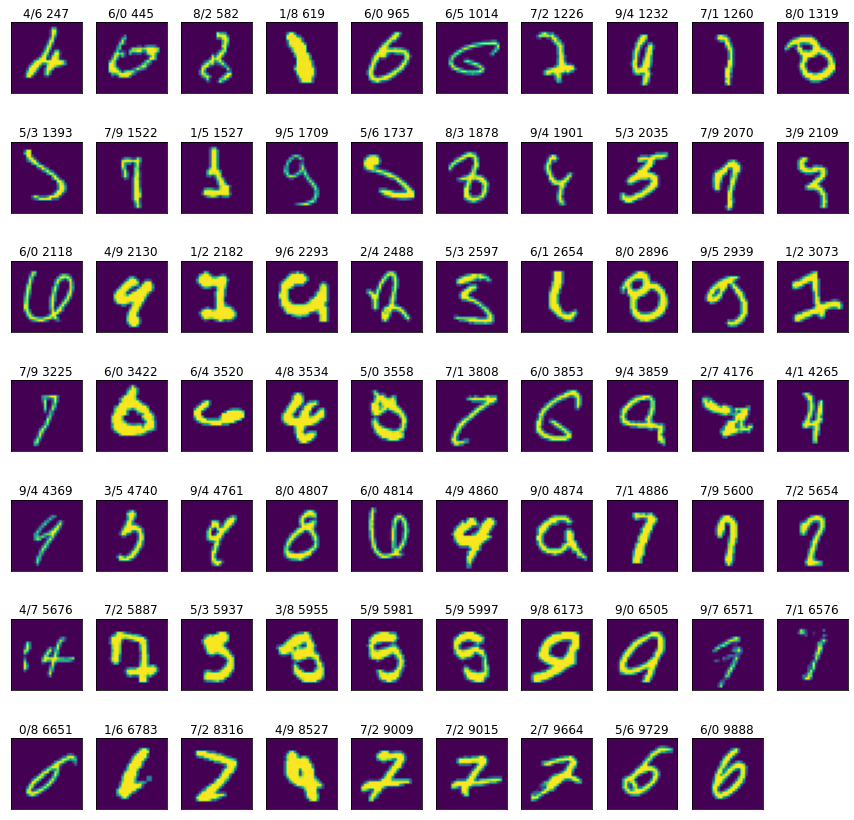

In [16]:
fail_list = []
fail_pred = []

i = 0
failures = 0
for img, label in mnist_test:
    img_org = img
    img = torch.unsqueeze(img, 0)  
    _, y_pred = model(img).max(1)
    if label == y_pred.item():
        i += 1
        continue
        
    failures +=1
    fail_list.append(i)
    fail_pred.append(y_pred.item())
    #print("%d, label=%d prediction=%d" % (i, label, y_pred.item()))
    i += 1

print("분류 실패 이미지 개수 = %d" % failures)
#print(fail_list)
#print(fail_pred)

row = failures // 10
if failures % 10 != 0:
    row += 1

fig = plt.figure(figsize=(15,15))

j = 0
for i in fail_list:
    img, label = mnist_test[i]
    ax = fig.add_subplot(row, 10, 1 + j, xticks=[], yticks=[])
    ax.set_title("{}/{} {}".format(label,fail_pred[j], i))  # label/prediction index
    plt.imshow(img.permute(1, 2, 0))
    j += 1
plt.show()

### (2) 훈련 이미지 각각을 분류하여 잘못 분류된 이미지들 보기

분류 실패 이미지 개수 = 245


Text(0.5, 1.0, '5/3 132')

Text(0.5, 1.0, '6/0 494')

Text(0.5, 1.0, '3/2 500')

Text(0.5, 1.0, '5/2 635')

Text(0.5, 1.0, '9/0 902')

Text(0.5, 1.0, '2/7 1047')

Text(0.5, 1.0, '3/8 1201')

Text(0.5, 1.0, '1/8 1375')

Text(0.5, 1.0, '8/6 1404')

Text(0.5, 1.0, '4/9 1604')

Text(0.5, 1.0, '1/8 2202')

Text(0.5, 1.0, '5/3 2554')

Text(0.5, 1.0, '7/2 2676')

Text(0.5, 1.0, '7/1 3692')

Text(0.5, 1.0, '9/4 3998')

Text(0.5, 1.0, '9/0 4362')

Text(0.5, 1.0, '2/1 4476')

Text(0.5, 1.0, '4/7 4822')

Text(0.5, 1.0, '2/8 5216')

Text(0.5, 1.0, '6/5 5554')

Text(0.5, 1.0, '9/4 5718')

Text(0.5, 1.0, '7/9 5821')

Text(0.5, 1.0, '8/5 6066')

Text(0.5, 1.0, '9/4 6092')

Text(0.5, 1.0, '3/8 6251')

Text(0.5, 1.0, '3/0 6269')

Text(0.5, 1.0, '3/8 6347')

Text(0.5, 1.0, '7/1 6707')

Text(0.5, 1.0, '3/5 7080')

Text(0.5, 1.0, '9/4 7264')

Text(0.5, 1.0, '5/6 7270')

Text(0.5, 1.0, '3/5 7784')

Text(0.5, 1.0, '2/1 8480')

Text(0.5, 1.0, '2/8 8670')

Text(0.5, 1.0, '6/0 8688')

Text(0.5, 1.0, '3/7 8729')

Text(0.5, 1.0, '1/8 9256')

Text(0.5, 1.0, '7/4 9433')

Text(0.5, 1.0, '1/0 10205')

Text(0.5, 1.0, '4/8 10241')

Text(0.5, 1.0, '7/9 10243')

Text(0.5, 1.0, '7/8 10251')

Text(0.5, 1.0, '7/8 10287')

Text(0.5, 1.0, '4/8 10313')

Text(0.5, 1.0, '7/8 10315')

Text(0.5, 1.0, '3/9 10994')

Text(0.5, 1.0, '4/7 11044')

Text(0.5, 1.0, '3/2 11104')

Text(0.5, 1.0, '8/9 11210')

Text(0.5, 1.0, '1/3 11342')

Text(0.5, 1.0, '7/2 12000')

Text(0.5, 1.0, '3/2 12183')

Text(0.5, 1.0, '4/9 12830')

Text(0.5, 1.0, '7/2 13662')

Text(0.5, 1.0, '8/4 14008')

Text(0.5, 1.0, '9/4 14582')

Text(0.5, 1.0, '1/2 14756')

Text(0.5, 1.0, '6/3 15450')

Text(0.5, 1.0, '8/5 15766')

Text(0.5, 1.0, '4/2 15942')

Text(0.5, 1.0, '1/7 16130')

Text(0.5, 1.0, '1/8 16376')

Text(0.5, 1.0, '3/8 16676')

Text(0.5, 1.0, '6/0 17401')

Text(0.5, 1.0, '9/7 17551')

Text(0.5, 1.0, '5/6 17739')

Text(0.5, 1.0, '9/0 17817')

Text(0.5, 1.0, '9/8 17958')

Text(0.5, 1.0, '8/0 18348')

Text(0.5, 1.0, '0/6 19360')

Text(0.5, 1.0, '9/4 19934')

Text(0.5, 1.0, '7/2 20226')

Text(0.5, 1.0, '4/9 20230')

Text(0.5, 1.0, '1/2 20672')

Text(0.5, 1.0, '9/0 20735')

Text(0.5, 1.0, '4/9 21130')

Text(0.5, 1.0, '9/0 21445')

Text(0.5, 1.0, '9/0 21686')

Text(0.5, 1.0, '1/8 21889')

Text(0.5, 1.0, '2/7 22200')

Text(0.5, 1.0, '3/8 22204')

Text(0.5, 1.0, '3/5 22675')

Text(0.5, 1.0, '7/9 22759')

Text(0.5, 1.0, '5/6 22779')

Text(0.5, 1.0, '7/1 23588')

Text(0.5, 1.0, '9/4 23710')

Text(0.5, 1.0, '5/9 23824')

Text(0.5, 1.0, '1/7 23911')

Text(0.5, 1.0, '1/2 24038')

Text(0.5, 1.0, '5/9 24426')

Text(0.5, 1.0, '4/9 24432')

Text(0.5, 1.0, '4/0 24798')

Text(0.5, 1.0, '6/0 24934')

Text(0.5, 1.0, '8/2 25546')

Text(0.5, 1.0, '9/7 25562')

Text(0.5, 1.0, '5/6 25678')

Text(0.5, 1.0, '5/9 26134')

Text(0.5, 1.0, '1/2 26376')

Text(0.5, 1.0, '9/0 26405')

Text(0.5, 1.0, '1/4 26444')

Text(0.5, 1.0, '8/5 26471')

Text(0.5, 1.0, '2/7 26504')

Text(0.5, 1.0, '8/2 26515')

Text(0.5, 1.0, '7/1 26560')

Text(0.5, 1.0, '6/4 26622')

Text(0.5, 1.0, '9/4 26748')

Text(0.5, 1.0, '7/9 26749')

Text(0.5, 1.0, '5/6 26842')

Text(0.5, 1.0, '7/8 27292')

Text(0.5, 1.0, '7/2 27522')

Text(0.5, 1.0, '6/5 27556')

Text(0.5, 1.0, '7/0 28014')

Text(0.5, 1.0, '6/0 28162')

Text(0.5, 1.0, '9/4 28422')

Text(0.5, 1.0, '8/6 28710')

Text(0.5, 1.0, '9/4 29180')

Text(0.5, 1.0, '4/9 29444')

Text(0.5, 1.0, '9/5 30049')

Text(0.5, 1.0, '9/4 30184')

Text(0.5, 1.0, '9/0 30646')

Text(0.5, 1.0, '4/7 30792')

Text(0.5, 1.0, '6/0 30968')

Text(0.5, 1.0, '3/2 31011')

Text(0.5, 1.0, '1/2 31134')

Text(0.5, 1.0, '7/9 31523')

Text(0.5, 1.0, '3/8 31596')

Text(0.5, 1.0, '7/3 31850')

Text(0.5, 1.0, '9/4 32342')

Text(0.5, 1.0, '5/0 32372')

Text(0.5, 1.0, '7/1 32571')

Text(0.5, 1.0, '9/4 32878')

Text(0.5, 1.0, '4/9 33506')

Text(0.5, 1.0, '9/8 34404')

Text(0.5, 1.0, '7/9 34861')

Text(0.5, 1.0, '4/6 35234')

Text(0.5, 1.0, '8/9 35246')

Text(0.5, 1.0, '5/6 35310')

Text(0.5, 1.0, '4/9 35324')

Text(0.5, 1.0, '9/8 35464')

Text(0.5, 1.0, '9/1 35480')

Text(0.5, 1.0, '6/4 35616')

Text(0.5, 1.0, '6/0 36446')

Text(0.5, 1.0, '1/7 36744')

Text(0.5, 1.0, '7/2 36760')

Text(0.5, 1.0, '7/1 36818')

Text(0.5, 1.0, '9/4 36934')

Text(0.5, 1.0, '1/2 37038')

Text(0.5, 1.0, '4/9 37450')

Text(0.5, 1.0, '5/6 37680')

Text(0.5, 1.0, '1/4 37816')

Text(0.5, 1.0, '7/1 37834')

Text(0.5, 1.0, '4/9 38052')

Text(0.5, 1.0, '4/6 38370')

Text(0.5, 1.0, '7/1 38374')

Text(0.5, 1.0, '5/7 38408')

Text(0.5, 1.0, '1/7 38700')

Text(0.5, 1.0, '5/9 38798')

Text(0.5, 1.0, '7/8 39289')

Text(0.5, 1.0, '8/6 39378')

Text(0.5, 1.0, '0/6 39683')

Text(0.5, 1.0, '7/9 39752')

Text(0.5, 1.0, '5/3 40144')

Text(0.5, 1.0, '7/9 40386')

Text(0.5, 1.0, '5/8 40654')

Text(0.5, 1.0, '1/2 40976')

Text(0.5, 1.0, '1/5 41424')

Text(0.5, 1.0, '6/8 41538')

Text(0.5, 1.0, '9/4 41594')

Text(0.5, 1.0, '5/8 41772')

Text(0.5, 1.0, '5/8 41904')

Text(0.5, 1.0, '9/4 42566')

Text(0.5, 1.0, '8/1 43109')

Text(0.5, 1.0, '5/3 43454')

Text(0.5, 1.0, '3/9 43658')

Text(0.5, 1.0, '9/4 43864')

Text(0.5, 1.0, '3/2 44456')

Text(0.5, 1.0, '7/1 45143')

Text(0.5, 1.0, '7/1 45185')

Text(0.5, 1.0, '9/7 45352')

Text(0.5, 1.0, '5/0 45616')

Text(0.5, 1.0, '9/7 45917')

Text(0.5, 1.0, '7/1 46078')

Text(0.5, 1.0, '8/0 46368')

Text(0.5, 1.0, '6/0 46432')

Text(0.5, 1.0, '3/8 46689')

Text(0.5, 1.0, '0/8 46726')

Text(0.5, 1.0, '3/8 46857')

Text(0.5, 1.0, '7/1 46938')

Text(0.5, 1.0, '4/9 47094')

Text(0.5, 1.0, '3/8 47689')

Text(0.5, 1.0, '7/1 48228')

Text(0.5, 1.0, '4/9 48486')

Text(0.5, 1.0, '4/9 48928')

Text(0.5, 1.0, '3/5 49006')

Text(0.5, 1.0, '6/2 49026')

Text(0.5, 1.0, '7/2 49212')

Text(0.5, 1.0, '8/9 49487')

Text(0.5, 1.0, '8/0 49543')

Text(0.5, 1.0, '1/2 49902')

Text(0.5, 1.0, '9/0 50239')

Text(0.5, 1.0, '3/2 50317')

Text(0.5, 1.0, '3/7 50340')

Text(0.5, 1.0, '3/9 50417')

Text(0.5, 1.0, '7/2 50605')

Text(0.5, 1.0, '9/0 50698')

Text(0.5, 1.0, '5/3 50881')

Text(0.5, 1.0, '9/4 51248')

Text(0.5, 1.0, '5/6 51764')

Text(0.5, 1.0, '4/9 51944')

Text(0.5, 1.0, '2/7 52144')

Text(0.5, 1.0, '1/6 52854')

Text(0.5, 1.0, '7/2 52899')

Text(0.5, 1.0, '8/2 52932')

Text(0.5, 1.0, '5/6 53063')

Text(0.5, 1.0, '9/0 53216')

Text(0.5, 1.0, '9/4 53396')

Text(0.5, 1.0, '5/8 53638')

Text(0.5, 1.0, '9/8 53976')

Text(0.5, 1.0, '8/0 53999')

Text(0.5, 1.0, '4/1 54264')

Text(0.5, 1.0, '1/6 54458')

Text(0.5, 1.0, '1/2 54506')

Text(0.5, 1.0, '7/9 54623')

Text(0.5, 1.0, '4/6 54778')

Text(0.5, 1.0, '3/2 54782')

Text(0.5, 1.0, '4/1 55340')

Text(0.5, 1.0, '1/2 55870')

Text(0.5, 1.0, '5/9 56224')

Text(0.5, 1.0, '4/7 56244')

Text(0.5, 1.0, '4/9 56596')

Text(0.5, 1.0, '9/4 56774')

Text(0.5, 1.0, '5/6 57302')

Text(0.5, 1.0, '5/6 57662')

Text(0.5, 1.0, '9/0 57728')

Text(0.5, 1.0, '9/4 57744')

Text(0.5, 1.0, '3/8 58064')

Text(0.5, 1.0, '1/6 58926')

Text(0.5, 1.0, '1/8 59354')

Text(0.5, 1.0, '5/3 59368')

Text(0.5, 1.0, '5/6 59701')

Text(0.5, 1.0, '9/5 59719')

Text(0.5, 1.0, '2/8 59720')

Text(0.5, 1.0, '7/9 59724')

Text(0.5, 1.0, '5/0 59747')

Text(0.5, 1.0, '4/7 59915')

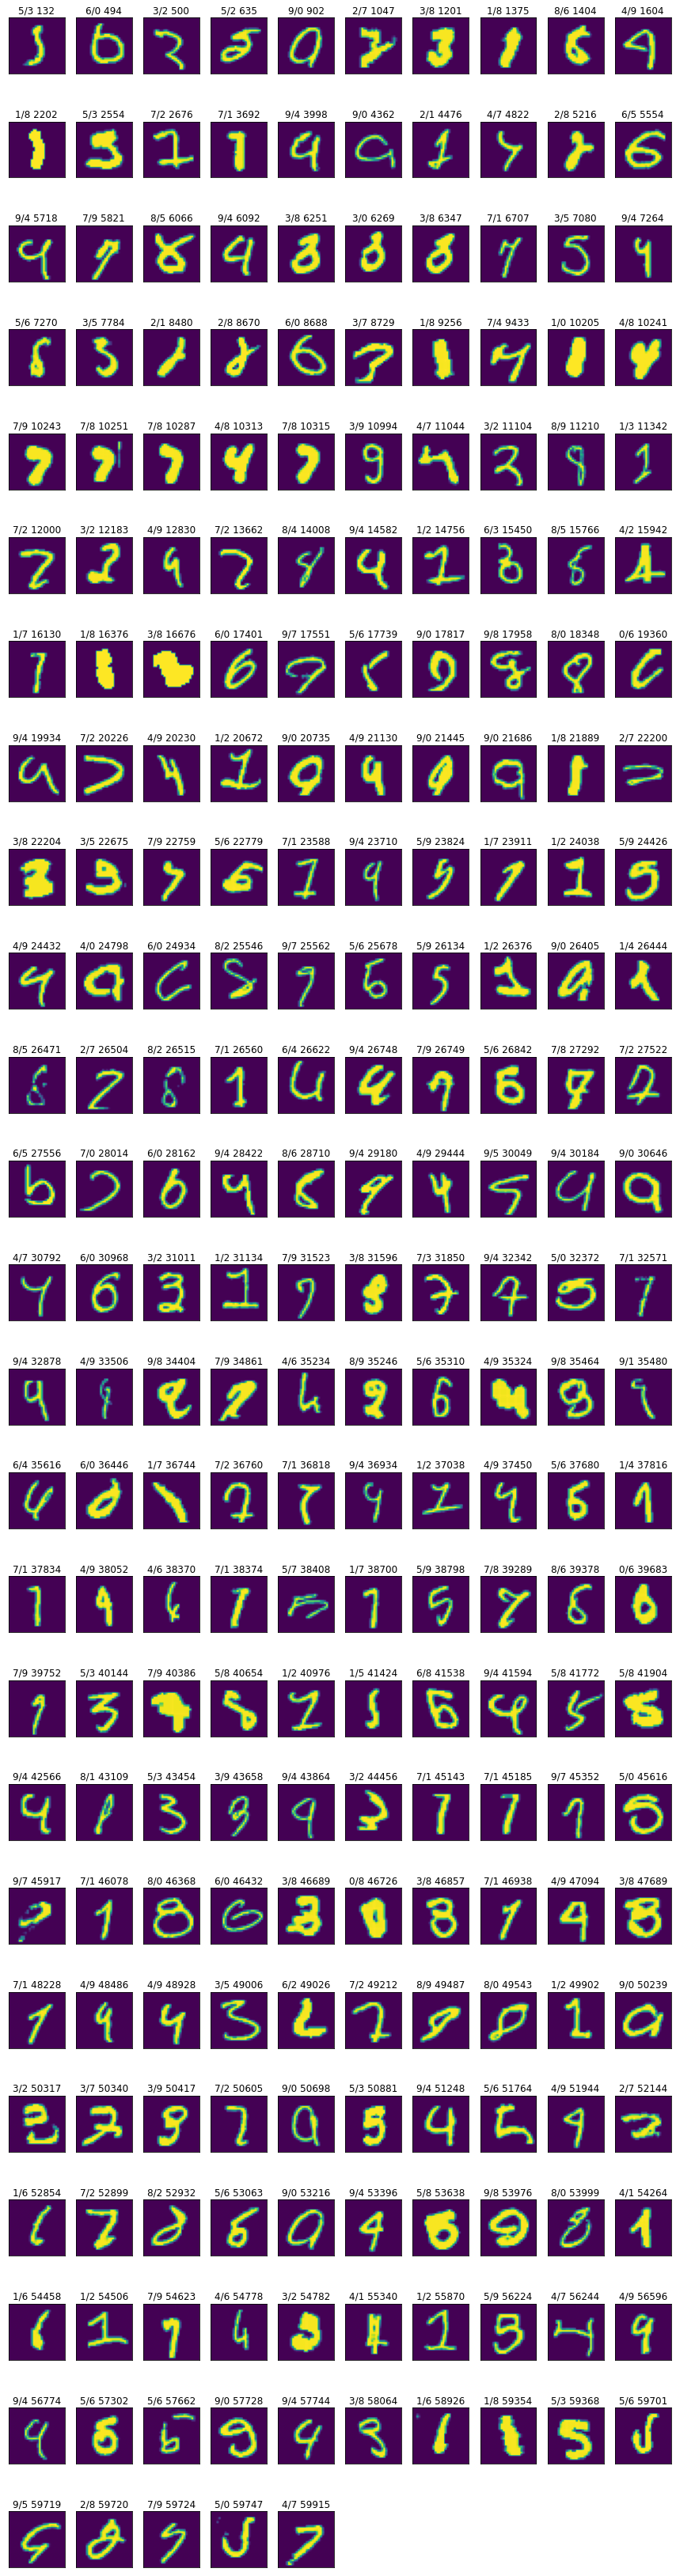

In [17]:
fail_list = []
fail_pred = []

i = 0
failures = 0
for img, label in mnist_train:
    img_org = img
    img = torch.unsqueeze(img, 0)  
    _, y_pred = model(img).max(1)
    if label == y_pred.item():
        i += 1
        continue
        
    failures +=1
    fail_list.append(i)
    fail_pred.append(y_pred.item())
    #print("%d, label=%d prediction=%d" % (i, label, y_pred.item()))
    i += 1

print("분류 실패 이미지 개수 = %d" % failures)
#print(fail_list)
#print(fail_pred)

row = failures // 10
if failures % 10 != 0:
    row += 1

fig = plt.figure(figsize=(15,60))

j = 0
for i in fail_list:
    img, label = mnist_train[i]
    ax = fig.add_subplot(row, 10, 1 + j, xticks=[], yticks=[])
    ax.set_title("{}/{} {}".format(label,fail_pred[j], i))  # label/prediction index
    plt.imshow(img.permute(1, 2, 0))
    j += 1
plt.show()